# Introduction
## The Data Set
In today's workshop, we will revisit the data set you worked with in the Machine Learning workshop. As a refresher:  this data set is from the GSE53987 dataset on Bipolar disorder (BD) and major depressive disorder (MDD) and schizophrenia:

Lanz TA, Joshi JJ, Reinhart V, Johnson K et al. STEP levels are unchanged in pre-frontal cortex and associative striatum in post-mortem human brain samples from subjects with schizophrenia, bipolar disorder and major depressive disorder. PLoS One 2015;10(3):e0121744. PMID: 25786133

This is a microarray data on platform GPL570 (HG-U133_Plus_2, Affymetrix Human Genome U133 Plus 2.0 Array) consisting of 54675 probes.

The raw CEL files of the GEO series were downloaded, frozen-RMA normalized, and the probes have been converted to HUGO gene symbols using the annotate package averaging on genes. The sample clinical data (meta-data) was parsed from the series matrix file. You can download it **here**.  

In total there are 205 rows consisting of 19 individuals diagnosed with BPD, 19 with MDD, 19 schizophrenia and 19 controls. Each sample has gene expression from 3 tissues (post-mortem brain). There are a total of 13768 genes (numeric features) and 10 meta features and 1 ID (GEO sample accession):

- Age
- Race (W for white and B for black)
- Gender (F for female and M for male)
- Ph: pH of the brain tissue
- Pmi: post mortal interval
- Rin: RNA integrity number
- Patient: Unique ID for each patient. Each patient has up to 3 tissue samples. The patient ID is written as disease followed by a number from 1 to 19
- Tissue: tissue the expression was obtained from.
- Disease.state: class of disease the patient belongs to: bipolar, schizophrenia, depression or control.
- source.name: combination of the tissue and disease.state

## Workshop Goals
This workshop will walk you through an analysis of the GSE53987 microarray data set. This workshop has the following three tasks:  
    1. Visualize the demographics of the data set  
    2. Cluster gene expression data and appropriately visualize the cluster results
    3. Compute differential gene expression and visualize the differential expression

Each task has a __required__ section and a __bonus__ section. Focus on completing the three __required__ sections first, then if you have time at the end, revisit the __bonus__ sections. 

Finally, as this is your final workshop, we hope that you will this as an opportunity to integrate the different concepts that you have learned in previous workshops.

## Workshop Logistics
As mentioned in the pre-workshop documentation, you can do this workshop either in a Jupyter Notebook, or in a python script. Please make sure you have set-up the appropriate environment for youself. This workshop will be completed using "paired-programming" and the "driver" will switch every 15 minutes. Also, we will be using the python plotting libraries matplotlib and seaborn. 

## TASK 0: Import Libraries and Data
- Download the data set (above) as a .csv file
- Initialize your script by loading the following libraries.

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import cluster, metrics, decomposition
from matplotlib import pyplot as plt
import itertools
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px

data = pd.read_csv('~/Downloads/GSE53987_combined.csv', index_col=0)
genes = data.columns[10:]

# TASK 1: Visualize Dataset Demographics  
## Required Workshop Task:  

1. Use the skeleton code to write 3 plotting functions:  
    1. plot_distribution()  
        - Returns a distribution plot object given a dataframe and one observation
    2. plot_relational()
        - Returns a distribution plot object given a dataframe and (x,y) observations  
    3. plot_categorical()
        - Returns a categorical plot object given a dataframe and (x,y) observations
2. Use these functions to produce the following plots:
    1. Histogram of patient ages
    2. Histogram of gene expression for 1 gene
    3. Scatter plot of gene expression for 1 gene by ages 
    4. Box plot of gene expression for 1 gene by disease state
    5. Violin plot of gene expression for 1 gene by Tissue
    
Your plots should satisfy the following critical components:  
* Axis titles
* Figure title
* Legend (if applicable)
* Be readable
    
### Bonus Task: 
1. Return to these functions and include functionality to customize color palettes, axis legends, etc. You can choose to define your own plotting "style" and keep that consistent for all of your plotting functions.  
2. Clean up any axis or tick labels so that all labels are clearly visible. This may include playing with text size, rotation, or some other parameter.


In [2]:
data.iloc[:, :12].head()

,Patient,Source.name,Age,Gender,Race,Pmi,Ph,Rin,Tissue,Disease.state,A1CF,A2M
GSM1304852,bipolar_10,"hippocampus, bipolar disorder",52,M,W,23.5,6.7,6.3,hippocampus,Bipolar disorder,4.670233,10.346901
GSM1304853,bipolar_11,"hippocampus, bipolar disorder",50,F,W,11.7,6.4,6.8,hippocampus,Bipolar disorder,5.013587,9.950699
GSM1304854,bipolar_12,"hippocampus, bipolar disorder",28,F,W,22.3,6.3,7.7,hippocampus,Bipolar disorder,4.693364,9.969120
GSM1304855,bipolar_13,"hippocampus, bipolar disorder",55,F,W,17.5,6.4,7.6,hippocampus,Bipolar disorder,4.843220,9.531571
GSM1304856,bipolar_14,"hippocampus, bipolar disorder",58,M,W,27.7,6.8,7.0,hippocampus,Bipolar disorder,4.851539,9.914055


/Users/andrewchen/miniforge3/envs/viz/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


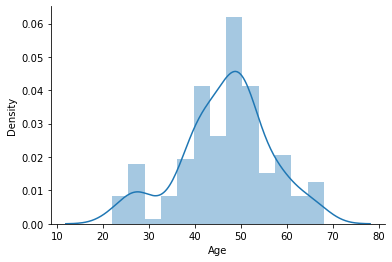

/Users/andrewchen/miniforge3/envs/viz/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


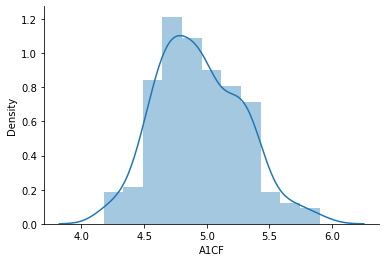

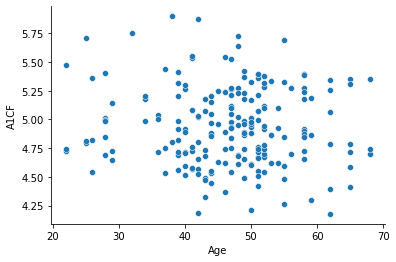

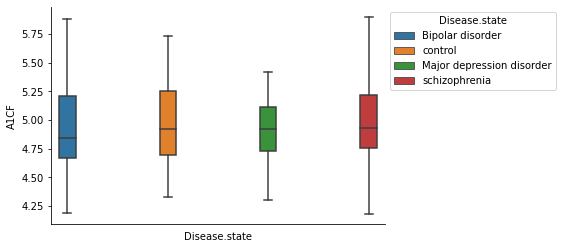

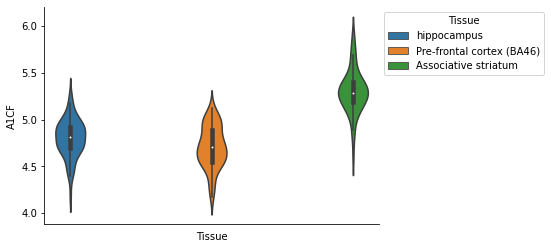

In [3]:

# Function to Plot a Distribtion
def plot_distribution(df, obs1, obs2=''):
    """
    Create a distribution plot for at least one observation
    
    Arguments:
        df (pandas data frame): data frame containing at least 1 column of numerical values
        obs1 (string): observation to plot distribution on
        obs2 (string, optional)
    Returns:
        axes object
    """
    if obs2 == '':
        ax = sns.distplot(df[obs1])
    else:
        ax = sns.FacetGrid(df, hue=obs2)
        ax = (g.map(sns.distplot, obs1, hist=False))
    return ax

# Function to Plot Relational (x,y) Plots 
def plot_relational(df, x, y, hue=None, kind=None):
    """
    Create a plot for an x,y relationship (default = scatter plot)
    Optional functionality for additional observations.
    
    Arguments:
        df (pandas data frame): data frame containing at least 2 columns of numerical values
        x (string): observation for the independent variable
        y (string): observation for the dependent variable
        hue (string, optional): additional observation to color the plot on
        kind (string, optional): type of plot to create [scatter, line]
    Returns:
        axes object
    """
    if kind == None or kind == "scatter":
        ax = sns.scatterplot(data=df, x=x, y=y, hue=hue)
    else:
        ax = sns.lineplot(data=df, x=x, y=y, hue=hue)
    return ax

def plot_categorical(df, x, y, hue=None, kind=None):
    """
    Create a plot for an x,y relationship where x is categorical (not numerical)
    
    Arguments:
        df (pandas data frame): data frame containing at least 2 columns of numerical values
        x (string): observation for the independent variable (categorical)
        y (string): observation for the dependent variable
        hue (string, optional): additional observation to color the plot on
        kind (string, optional): type of plot to create. Options should include at least: 
        strip (default), box, and violin
    """
    if kind == None or kind == "strip":
        ax = sns.stripplot(data=df, x=x, y=y, hue=hue)
    elif kind == "violin":
        ax = sns.violinplot(data=df, x=x, y=y, hue=hue)
    elif kind == "box":
        ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
    return ax

def main(data):
    """
    Generate the following plots:
    1. Histogram of patient ages
    2. Histogram of gene expression for 1 gene
    3. Scatter plot of gene expression for 1 gene by ages 
    4. Box plot of gene expression for 1 gene by disease state
    5. Violin plot of gene expression for 1 gene by Tissue
    """
    plot_distribution(data, "Age")
    sns.despine()
    plt.show()
    plot_distribution(data, "A1CF")
    sns.despine()
    plt.show()
    plot_relational(data, "Age", "A1CF")
    sns.despine()
    plt.show()
    ax = plot_categorical(data, 'Disease.state', 'A1CF', hue='Disease.state', kind='box')
    ax.set_xticks([])
    ax.legend_.set_bbox_to_anchor((1, 1))
    sns.despine()
    plt.show()
    ax = plot_categorical(data, 'Tissue', 'A1CF', hue='Tissue', kind='violin')
    ax.set_xticks([])
    ax.legend_.set_bbox_to_anchor((1, 1))
    sns.despine()
main(data)

## TASK 2: Differential Expression Analysis

Differential expression analysis is a fancy way of saying, "We want to find which genes exhibit increased or decreased expression compared to a control group". Neat. Because the dataset we're working with is MicroArray data -- which is mostly normally distributed -- we'll be using a simple One-Way ANOVA. If, however, you were working with sequence data -- which follows a Negative Binomial distribution -- you would need more specialized tools. A helper function is provided below.

In [4]:
def bh_adjust(pvalues):
    from scipy.stats import rankdata
    ranked_pvalues = rankdata(pvalues)
    fdr = pvalues * len(pvalues) / ranked_pvalues
    fdr[fdr > 1] = 1

    return fdr

def differential_expression(data, group_col, features, reference=None):
    """
    Perform a one-way ANOVA across all provided features for a given grouping.
    
    Arguments
    ---------
    
        data : (pandas.DataFrame)
            DataFrame containing group information and feature values.
        group_col : (str)
            Column in `data` containing sample group labels.
        features : (list, numpy.ndarray):
            Columns in `data` to test for differential expression. Having them
            be gene names would make sense. :thinking:
        reference : (str, optional)
            Value in `group_col` to use as the reference group. Default is None,
            and the value will be chosen.
            
    Returns
    -------
        pandas.DataFrame
            A DataFrame of differential expression results with columns for
            fold changes between groups, maximum fold change from reference,
            f values, p values, and adjusted p-values by Bonferroni correction.
    """
    if group_col not in data.columns:
        raise ValueError("`group_col` {} not found in data".format(group_col))
    if any([x not in data.columns for x in features]):
        raise ValueError("Not all provided features found in data.")
    if reference is None:
        reference = data[group_col].unique()[0]
        print("No reference group provided. Using {}".format(reference))
    elif reference not in data[group_col].unique():
        raise ValueError("Reference value {} not found in column {}.".format(
                         reference, group_col))
    by_group = data.groupby(group_col)
    reference_avg = by_group.get_group(reference).loc[:,features].mean()
    values = []
    results = {}
    for each, index in by_group.groups.items():
        values.append(data.loc[index, features])
        if each !=  reference:
            key = f"{each.replace(' ', '_')}_foldchange"
            results[key] = np.log2(data.loc[index, features].mean()) \
                         - np.log2(reference_avg)
    fold_change_cols = list(results.keys())
    fvalues, pvalues = stats.f_oneway(*values)
    results['f_value'] = fvalues
    results['p_value'] = pvalues
    results['neg_log10_pvalue'] = - np.log10(pvalues)
    results['adj_p_value'] = bh_adjust(pvalues)
    results_df = pd.DataFrame(results)
    def largest_deviation(x):
        i = np.where(abs(x) == max(abs(x)))[0][0]
        return x[i]
    if len(fold_change_cols) > 0:
        results_df['max_foldchange'] = results_df[fold_change_cols].apply(
                                           lambda x: largest_deviation(x.values), axis=1)

    return results_df  

## Task 2a: Volcano Plots

Volcano plots are ways to showcase the number of differentially expressed genes found during high throughput sequencing analysis. Log fold changes are plotted along the x-axis, while p-values are plotted along the y-axis. Genes are marked significant if they exceed some absolute Log fold change theshold **as well** some p-value level for significance. This can be seen in the plot below.

![](https://galaxyproject.github.io/training-material/topics/transcriptomics/images/rna-seq-viz-with-volcanoplot/volcanoplot.png)

Your first task will be to generate some Volcano plots:

## Requirments 
1. Use the provided function to perform an ANOVA (analysis of variance) between control and experimental groups in each tissue.
    - Perform a separate analysis for each tissue.
2. Implement the skeleton function to create a volcano plot to visualize both the log fold change in expression values and the p-values from the ANOVA comparison
3. Highlight significant genes with distinct colors

**hints**:
1. You might find the `palette` argument for seaborn plots helpful when coloring each gene
2. Volcano plots are typically a little strange where _significance_ is determined by **adjusted** p-values, but **raw** -$log_{10}$ p-values are plotted along the y-axis

In [5]:
def volcano_plot(data, x_col, y_col, sig_col, sig_thresh, fc_thresh):
    """
    Generate a volcano plot to showcasing differentially expressed genes.
    
    Parameters
    ----------
        data : (pandas.DataFrame)
            A data frame containing differential expression results
        x_col : str
            Column to plot along x-axis, typically log2(foldchange)
        y_col : str
            Column to plot along y-axis, typically -log10(p-value)
        sig_col : str
            Column in `data` with adjusted p-values.
        sig_thresh : float
            Threshold for statistical significance.
        fc_thresh : float
            Threshold for biological significance 
    """
    data['significant'] = False
    def get_direction(fc, p_value):
        if p_value < sig_thresh and abs(fc) > fc_thresh:
            if fc > 0:
                return "Up"
            else:
                return "Down"
        else:
            return "Not Sig."
    data["DE"] = data.apply(lambda x: get_direction(x[x_col], x[sig_col]), axis=1)
    sig_y = data[data.DE != "Not Sig."][y_col].min()
    ax = sns.scatterplot(x=x_col, y=y_col, hue='DE', data=data,
                         palette={"Not Sig.": "gray", 'Up': "red", "Down": "blue"}, alpha=0.75)
    linewidth = plt.rcParams['lines.linewidth'] - 1
    ax.axvline(x=fc_thresh, linestyle='--', linewidth=linewidth,
                color='#4D4E4F')
    ax.axvline(x=-fc_thresh, linestyle='--', linewidth=linewidth,
                color='#4D4E4F')
    ax.axhline(y=sig_y, linestyle='--', linewidth=linewidth,
                color='#4D4E4F')
    ylabel = sig_col
    if sig_col.lower() == 'fdr':
        ylabel = 'False Discovery Rate'
    ax.set_xlabel(r"$log_2$ Fold Change")
    ax.set_ylabel("$-log10$ p-value")
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    return ax

## Example code for general dataset

,Bipolar_disorder_foldchange,Major_depression_disorder_foldchange,schizophrenia_foldchange,f_value,p_value,neg_log10_pvalue,adj_p_value,max_foldchange,significant,DE
A1CF,-0.010506,-0.003838,0.013639,0.516227,0.671564,0.172913,0.916090,0.013639,False,Not Sig.
A2M,-0.013420,-0.002147,-0.034927,3.016441,0.031022,1.508330,0.170913,-0.034927,False,Not Sig.
A4GALT,0.012454,0.014728,0.025965,1.318951,0.269331,0.569714,0.620715,0.025965,False,Not Sig.
A4GNT,-0.005684,-0.006788,-0.016534,0.798691,0.495908,0.304599,0.819056,-0.016534,False,Not Sig.
AAAS,-0.005946,-0.002742,0.000289,0.437122,0.726677,0.138659,0.939338,-0.005946,False,Not Sig.


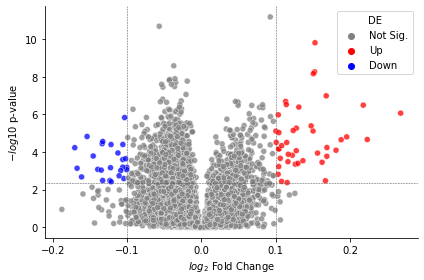

In [6]:
de_res = differential_expression(data, "Disease.state", features=data.columns[10:], reference="control")
volcano_plot(de_res, y_col='neg_log10_pvalue', x_col="max_foldchange", sig_col="adj_p_value", sig_thresh=0.05, fc_thresh=0.1)
de_res.head()

## Generate and Plot Tissue-specific Volcano Plots

### Hippocampus DE

<AxesSubplot:xlabel='$log_2$ Fold Change', ylabel='$-log10$ p-value'>

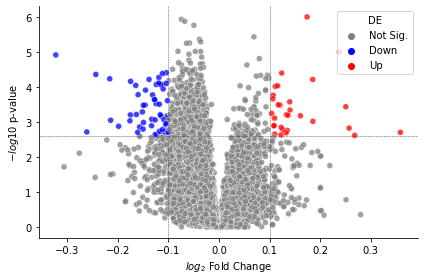

In [7]:
# Here's some pre-subsetted data
hippocampus = data[data["Tissue"] == "hippocampus"]

hippo_de = differential_expression(hippocampus, "Disease.state",  features=data.columns[10:], reference="control")
volcano_plot(hippo_de, y_col='neg_log10_pvalue', x_col="max_foldchange", sig_col="adj_p_value", sig_thresh=0.05, fc_thresh=0.1)

### Pre-frontal Cortex Volcano Plot

<AxesSubplot:xlabel='$log_2$ Fold Change', ylabel='$-log10$ p-value'>

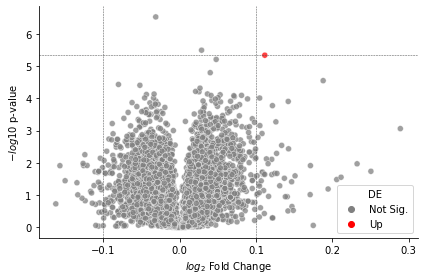

In [8]:
pf_cortex = data[data["Tissue"] == "Pre-frontal cortex (BA46)"]
pf_de = differential_expression(pf_cortex, "Disease.state",  features=data.columns[10:], reference="control")
volcano_plot(pf_de, y_col='neg_log10_pvalue', x_col="max_foldchange", sig_col="adj_p_value", sig_thresh=0.05, fc_thresh=0.1)

### Associative Striatum Volcano Plot

<AxesSubplot:xlabel='$log_2$ Fold Change', ylabel='$-log10$ p-value'>

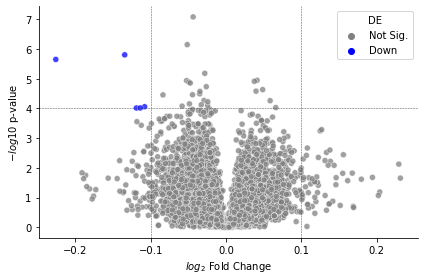

In [9]:
as_striatum = data[data["Tissue"] == "Associative striatum"]
as_de = differential_expression(as_striatum, "Disease.state",  features=data.columns[10:], reference="control")
volcano_plot(as_de, y_col='neg_log10_pvalue', x_col="max_foldchange", sig_col="adj_p_value", sig_thresh=0.05, fc_thresh=0.1)

## Task 2b: Plot the Top 100 Differentially Expressed Genes

Clustered heatmaps are hugely popular for displaying differences in gene expression values. To reference such a plot, look back at the introductory material. Here we will be plotting the 100 most differentially expressed genes for each of the analysis performed before.

### Requirements
- Implement the skeleton function below
- Z normalize gene values
- To visualize the effects of row and cluster ordering on data presentation, make heatmaps that are both clustered and not clustered
- Use a diverging and perceptually uniform colormap
- Annotate rows using `row_colors` parameter in `sns.clustermap` to color rows by disease status or tissue of origin

**Hints**:
1. Look over all the options for [sns.clustermap()](https://seaborn.pydata.org/generated/seaborn.clustermap.html). It might make things easier.
2. The data we are plotting is the **expression** values, not the direct DE results
3. We've provided a helper function to get the top $n$ genes from a DE comparison `get_top_genes()` as well as to generate and additional legend

In [10]:
def get_top_genes(de_results, pval_col, n_genes):
    """
    Return to the top n genes from a differential expression analysis comparison.
    
    Parameters
    ----------
    de_results : pd.DataFrame
        A table containing results from a DE analysis run
    pval_col : str
        A column in `de_results` containing p-values
    n_genes : int
        The number of genes to return
    """
    return de_results.sort_values(pval_col, ascending=True).iloc[:n_genes, :].index.values

def plot_legend(palette_dict, col_name):
    """Generate plot legend using a dictionary mapping values to color codes"""
    from matplotlib import patches as mpatches
    handles = [
        mpatches.Patch(facecolor=each)
        for each in palette_dict.values()
    ]
    plt.legend(
        handles,
        list(palette_dict.keys()),
        title=col_name,
        bbox_to_anchor=(1, 1),
        bbox_transform=plt.gcf().transFigure,
        loc="upper left",
    )

def heatmap(data, genes, row_color, cluster=False):
    """
    Plot heatmap over provided genes.
    
    Parameters
    ----------
    data : pd.DataFrame
        A (sample x gene) data matrix containing gene expression values for each sample.
    genes : list, str
        List of genes to plot
    row_color : str
        Column in `data` containing categorical data to color rows by
    cluster : bool
        Whether to order rows and column by dendrogram.
    """
    plot_data = data.loc[:, genes]
    palette_dict = {}
    for i, each in enumerate(data[row_color].unique()):
        palette_dict[each] = sns.color_palette()[i]
    dendro_ratio = 0.2
    if not cluster:
        dendro_ratio=0.125
    fig = sns.clustermap(
        plot_data,
        cmap='RdBu_r',
        z_score=1,
        row_colors=data[row_color].map(palette_dict),
        xticklabels=False,
        yticklabels=False,
        dendrogram_ratio=dendro_ratio,
        row_cluster=cluster,
        col_cluster=cluster,
    )
    plot_legend(palette_dict, row_color)
    return fig


/Users/andrewchen/miniforge3/envs/viz/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


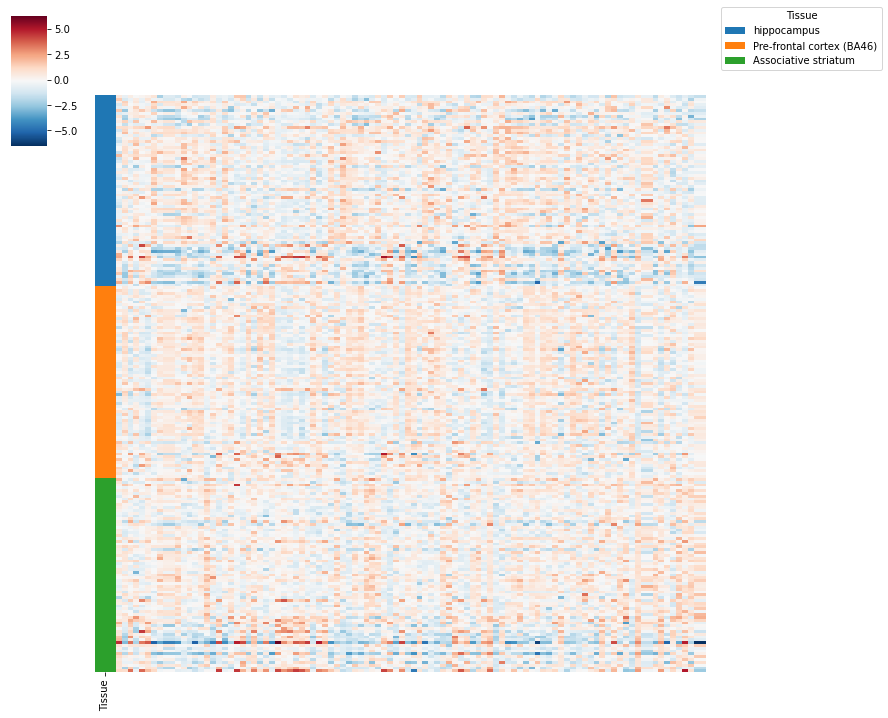

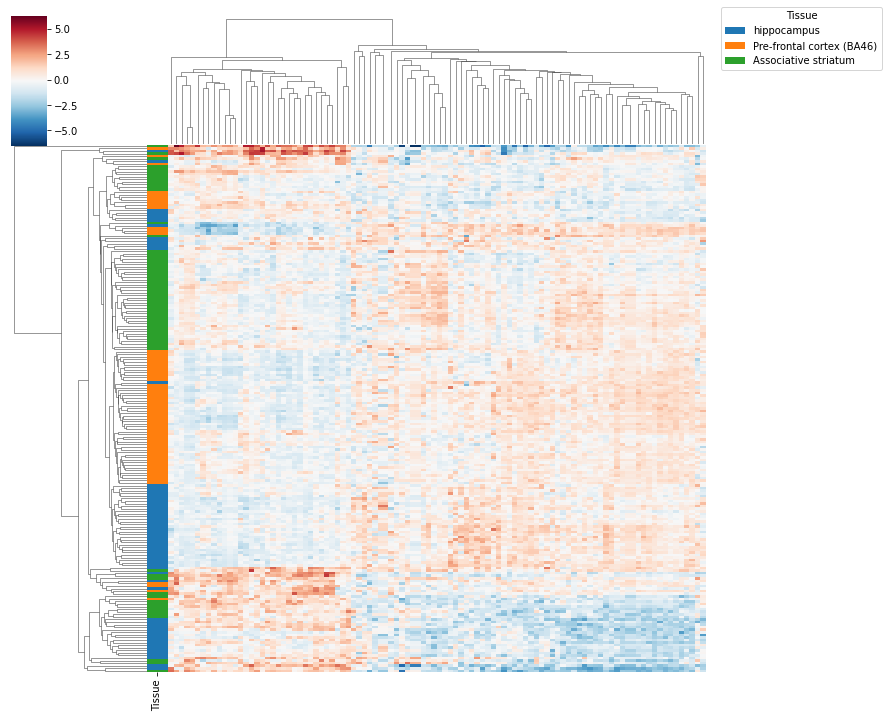

In [11]:
top_genes = get_top_genes(de_res, 'p_value', 100)
heatmap(data, top_genes, row_color="Tissue", cluster=False)
heatmap(data, top_genes, row_color="Tissue", cluster=True)

### Bonus
The above results were all done on disease comparisons across multiple tissues. Another question we could ask is if there are any genes that are differentially expressed between the tissues themselves. Repeat the above analysis by subsetting the data down to control samples only, and perform DE analysis betweeen tissues. Plot the results as a volcano plot as well as a clustered heatmap

*hint*: we used a very low $log_2$ fold change cutoff during the previous steps, it may be worth increasing that threshold for this analysis

<AxesSubplot:xlabel='$log_2$ Fold Change', ylabel='$-log10$ p-value'>

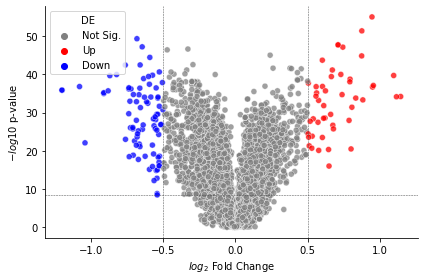

In [12]:
controls = data[data['Disease.state'] == 'control']
tissue_res = differential_expression(controls, "Tissue", features=data.columns[10:], reference="hippocampus")
volcano_plot(tissue_res, y_col='neg_log10_pvalue', x_col="max_foldchange", sig_col="adj_p_value", sig_thresh=0.05, fc_thresh=0.5)

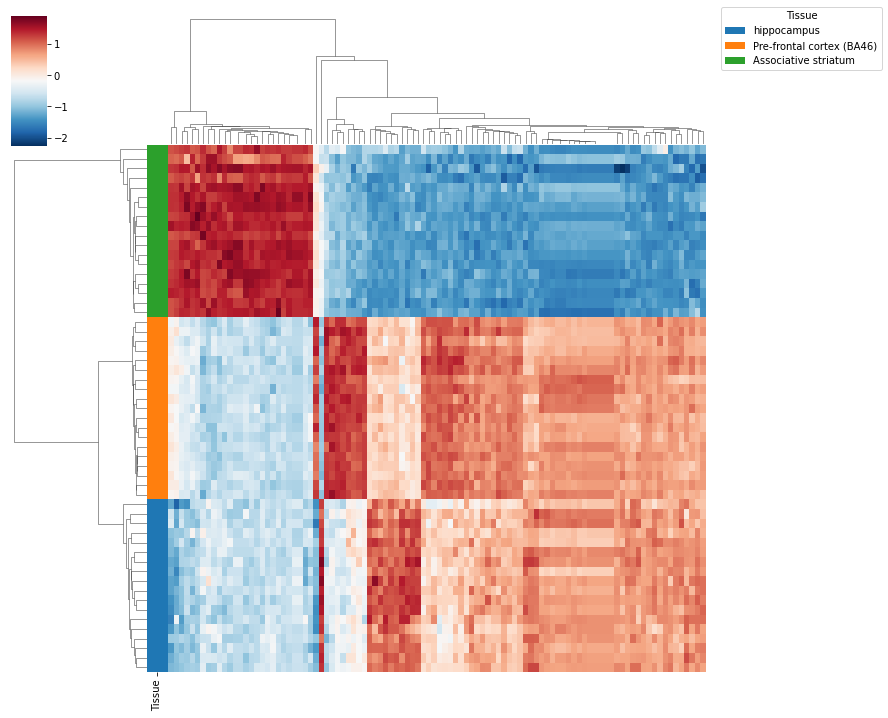

In [13]:
top_genes = get_top_genes(tissue_res, 'p_value', 100)
heatmap(controls, top_genes, row_color="Tissue", cluster=True)

# Task 3: Subplots and Facet Grids

Often we want to combine multiple plots into one larger figure for presentations, articles, publications. This is where `plt.subplots` comes in handy!

## Task 3A: Combining Violin Plots into one figure

For Task 2B, we found the top 100 DE genes in order to plot a heatmap. For the top 3 DE genes, let's compare the expression of control samples vs. schizophrenia samples in each of the three tissues.

_Hints_
- `sns.violinplot` has options for x,y, and hue. Assigning `hue` to the `Disease.state` allows for easy comparisons between control and schizophrenia. 
- You might get too many legends! You can control which axis has a legend using `ax.legend().set_visible(False)`

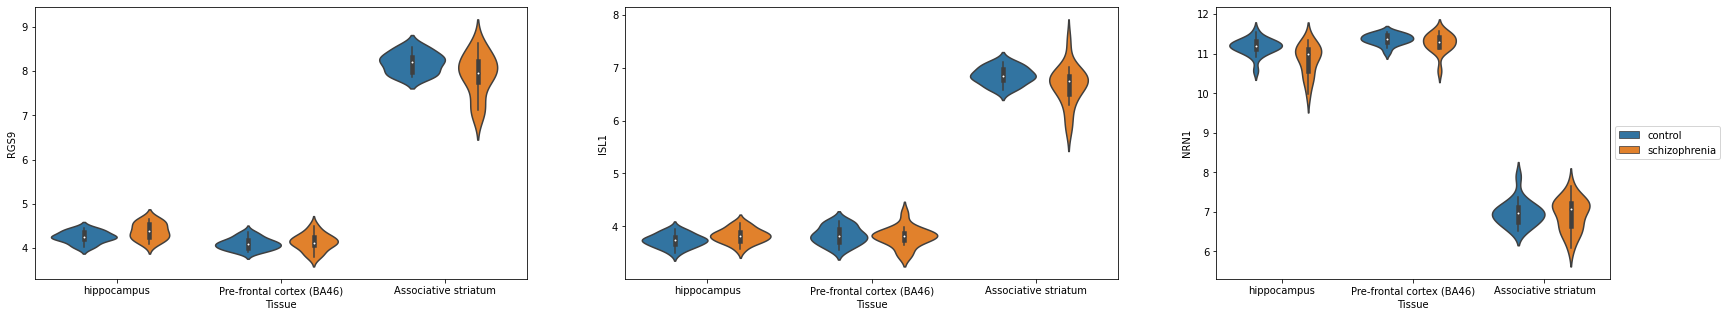

In [17]:
def main():
    top_three = top_genes[:3]
    tissues = data['Tissue'].unique()
    data_disease_state_filter = data[(data['Disease.state'] == 'control') | (data['Disease.state'] == 'schizophrenia')]

    fig, axs = plt.subplots(1,3,figsize=(30,5))
    for gene, ax in zip(top_three, axs.flatten()):
        sns.violinplot(ax = ax, data=data_disease_state_filter, x='Tissue', y=gene, hue="Disease.state")
        ax.legend().set_visible(False)
    
    # Create some space to add legend to the left of the figure
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

main()

## Task 3B: Combining Volcano plots into one figure
### Requirements
- Implement the skeleton function to create a figure with three volcano plots for each of the three tissues using both `plt.subplots` 
- Highlight significant genes for each plot
- Add titles for each of the sub-plots

**Hints**:
1. Look for axes options in [sns.scatterplot()](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).
2. `plt.subplots()` creates a grid of individual axes. You can access each of these individual axes using indices e.g. `axs[0]`

In [18]:
hippo_de = differential_expression(hippocampus, "Disease.state",  features=data.columns[10:], reference="control")
pf_de = differential_expression(pf_cortex, "Disease.state",  features=data.columns[10:], reference="control")
as_de = differential_expression(as_striatum, "Disease.state",  features=data.columns[10:], reference="control")

combined_de = [hippo_de, pf_de, as_de]
labels = ['Hippocampus', 'Pre-frontal cortex', 'Associative striatum']

In [19]:
def volcano_plot_combined(dfs, labels, x_col, y_col, sig_col, sig_thresh, fc_thresh):
    """
    Generate a volcano plot to showcasing differentially expressed genes.
    
    Parameters
    ----------
        dfs : List of pandas.DataFrame
            A list of data frames containing differential expression results
        labels : List of str
        x_col : str
            Column to plot along x-axis, typically log2(foldchange)
        y_col : str
            Column to plot along y-axis, typically -log10(p-value)
        sig_col : str
            Column in `df` with adjusted p-values.
        sig_thresh : float
            Threshold for statistical significance.
        fc_thresh : float
            Threshold for biological significance 
    """
    # Helper function to find the adjusted p-value cutoff for plotting purposes
    def find_sig_y(df, x_col, y_col, sig_col, sig_thresh, fc_thresh):
        df['significant'] = False
        def get_direction(fc, p_value):
            if p_value < sig_thresh and abs(fc) > fc_thresh:
                if fc > 0:
                    return "Up"
                else:
                    return "Down"
            else:
                return "Not Sig."

        df["DE"] = df.apply(lambda x: get_direction(x[x_col], x[sig_col]), axis=1)
        sig_y = df[df.DE != "Not Sig."][y_col].min()
        return sig_y


    # Plot each volcano plot onto the same figure
    n_dfs = len(dfs)
    n_rows = 1
    n_cols = n_dfs
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,5))

    for i in range(n_dfs):
        sig_y = find_sig_y(dfs[i], x_col, y_col, sig_col, sig_thresh, fc_thresh)

        ax = sns.scatterplot(ax = axs[i], x=x_col, y=y_col, hue='DE', data=dfs[i],
                            palette={"Not Sig.": "gray", 'Up': "red", "Down": "blue"}, alpha=0.75)
        linewidth = plt.rcParams['lines.linewidth'] - 1

        ax.set_title(labels[i])
        ax.axvline(x=fc_thresh, linestyle='--', linewidth=linewidth,
                color='#4D4E4F')
        ax.axvline(x=-fc_thresh, linestyle='--', linewidth=linewidth,
                color='#4D4E4F')
        ax.axhline(y=sig_y, linestyle='--', linewidth=linewidth,
                color='#4D4E4F')
        ylabel = sig_col
        if sig_col.lower() == 'fdr':
            ylabel = 'False Discovery Rate'
        ax.set_xlabel(r"$log_2$ Fold Change")
        ax.set_ylabel("$-log10$ p-value")
        for spine in ['right', 'top']:
            ax.spines[spine].set_visible(False)

    plt.tight_layout()
    return axs

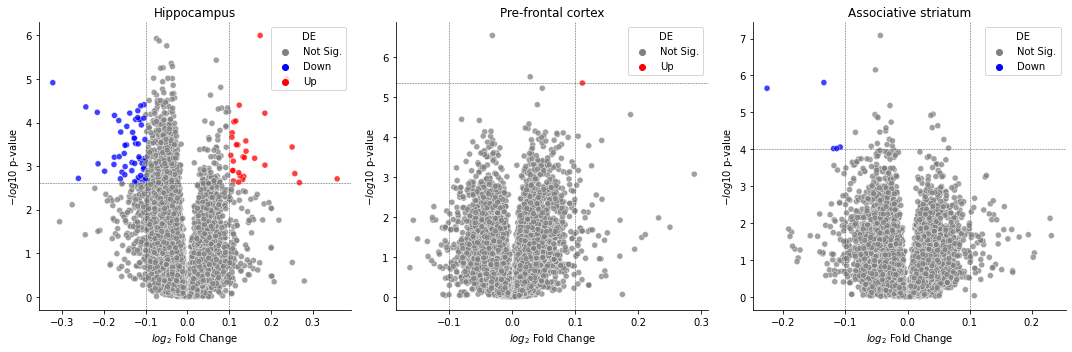

In [20]:
volcano_plot_combined(combined_de, labels, x_col="max_foldchange", y_col="neg_log10_pvalue", sig_col="adj_p_value", sig_thresh=0.05, fc_thresh=0.1);